<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/feature_engineering/CA_Labeling_CDC_Guideline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

* This colab is for labeling CA data from combined datasets and maryland intertia dataset following CDC guideline 



In [ ]:
# Task 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a2e3f840beeb6038556ad23162b1c9d3b5de3a2bb94cfb5e6367b8867a023ff0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan14.csv
 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_alldatasets_Jan13.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_processedMarylandData_Jan11.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_processedMarylandData_Jan11.csv
 TX_processedMarylandData_Jan11.gsheet
 TX_SocialDistancingDataJan10.csv


### Location

In [6]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

# Load County Population


In [5]:
county_population_US = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv',low_memory=False)
print(county_population_US.shape)

(3195, 4)


In [6]:
wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv('covid_county_population_usafacts.csv',low_memory=False)
print(county_population_US.shape)


(3195, 4)


In [7]:
county_population_US = county_population_US.rename(columns={"population": "county_population"})

In [8]:
county_population_US.head(2)

,countyFIPS,County Name,State,county_population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


# Load Combined Dataset

## Data Preprocessing

In [10]:
CA_combined_data = pd.read_csv(location+'CA_alldatasets_Jan13.csv',low_memory=False)
CA_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0


## 'New Cases/100k population'

In [11]:
CA_combined_data['New Cases/100k population'] = CA_combined_data['New cases']*100000/ CA_combined_data['population']
CA_combined_data.tail(2)

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population
15819,2021-01-04,California,6115,36,Yuba County,78668,1,0.074,0,-18.0,-8.0,-2.0,-32.0,-35.0,12.0,45.761936
15820,2021-01-05,California,6115,102,Yuba County,78668,1,0.574,6,-14.0,-6.0,NaN,-26.0,-30.0,10.0,129.658819


## Merge with County Population

In [ ]:
CA_combined_data = pd.merge(CA_combined_data,county_population_US,how='inner',left_on=['fips_x'],right_on=['countyFIPS'])
print(CA_combined_data.shape)

(9196, 22)


In [ ]:
CA_combined_data.head(5)

,Date,fips_x,County Name_x,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,County Name_y,State,county_population
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.059833,6001,Alameda County,CA,1671329
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.000000,6001,Alameda County,CA,1671329


In [ ]:
CA_combined_data = CA_combined_data.drop(['County Name_y'], axis = 1) 


In [ ]:
CA_combined_data = CA_combined_data.rename(columns={"County Name_x": "County Name", "fips_x":"fips"})

In [ ]:
CA_combined_data.head(3)

,Date,fips,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/100k population,countyFIPS,State,county_population
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000,6001,CA,1671329
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000,6001,CA,1671329
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.059833,6001,CA,1671329


## Computing rolling average

In [13]:
CA_combined_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'population', 'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'New Cases/100k population'],
      dtype='object')

In [15]:
col_idx = CA_combined_data.columns.get_loc("New Cases/100k population")
print(col_idx)

15


15 no column  = New Cases/100k population

In [16]:
CA_combined_data.iloc[:,col_idx]

0          0.000000
1          0.000000
2          0.059833
3          0.000000
4          0.000000
            ...    
15816     50.846596
15817      0.000000
15818     40.677277
15819     45.761936
15820    129.658819
Name: New Cases/100k population, Length: 15821, dtype: float64

### Filter CA

In [19]:
CA_combined_data = CA_combined_data.loc[CA_combined_data['Province_State'] == 'California']
CA_combined_data.reset_index(drop=True)

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,0.000000
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,0.000000
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,0.059833
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,0.000000
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15816,2021-01-01,California,6115,40,Yuba County,78668,1,0.427,4,-36.0,-23.0,18.0,-55.0,-68.0,22.0,50.846596
15817,2021-01-02,California,6115,0,Yuba County,78668,1,1.502,15,-17.0,-11.0,8.0,-41.0,-19.0,8.0,0.000000
15818,2021-01-03,California,6115,32,Yuba County,78668,1,0.161,1,-11.0,-7.0,33.0,NaN,-10.0,5.0,40.677277
15819,2021-01-04,California,6115,36,Yuba County,78668,1,0.074,0,-18.0,-8.0,-2.0,-32.0,-35.0,12.0,45.761936


In [20]:
CA_combined_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'population', 'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'New Cases/100k population'],
      dtype='object')

old

['Date', 'Province_State', 'FIPS','County Name','population',
                           'retail and recreation','grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'New Cases/100k population', 'countyFIPS', 'State',
       'county_population','rolling_avg_new_cases/100k']

In [21]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS','County Name','population',
                           'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'New Cases/100k population','rolling_avg_new_cases/100k'])


In [23]:
col_idx = CA_combined_data.columns.get_loc("New Cases/100k population")
print(col_idx)

15


In [24]:
CA_counties = CA_combined_data['County Name'].unique()

for county in CA_counties:
  county_data = CA_combined_data[CA_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases/100k'] = county_data.iloc[:,col_idx].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
0,2020-03-01,California,6001,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,0.000000,NaN,0.0
1,2020-03-02,California,6001,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,0.000000,NaN,0.0
2,2020-03-03,California,6001,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,0.059833,NaN,1.0
3,2020-03-04,California,6001,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,0.000000,NaN,0.0
4,2020-03-05,California,6001,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,0.000000,NaN,0.0


In [25]:
print(df.shape)
CA_combined_data.shape

(15821, 17)


(15821, 16)

In [26]:
CA_combined_data = df.copy()
CA_combined_data

,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
0,2020-03-01,California,6001,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,0.000000,NaN,0.0
1,2020-03-02,California,6001,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,0.000000,NaN,0.0
2,2020-03-03,California,6001,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,0.059833,NaN,1.0
3,2020-03-04,California,6001,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,0.000000,NaN,0.0
4,2020-03-05,California,6001,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,0.000000,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15816,2021-01-01,California,6115,Yuba County,78668,1,0.427,4,-36.0,-23.0,18.0,-55.0,-68.0,22.0,50.846596,49.030646,40.0
15817,2021-01-02,California,6115,Yuba County,78668,1,1.502,15,-17.0,-11.0,8.0,-41.0,-19.0,8.0,0.000000,49.030646,0.0
15818,2021-01-03,California,6115,Yuba County,78668,1,0.161,1,-11.0,-7.0,33.0,NaN,-10.0,5.0,40.677277,54.841685,32.0
15819,2021-01-04,California,6115,Yuba County,78668,1,0.074,0,-18.0,-8.0,-2.0,-32.0,-35.0,12.0,45.761936,54.660091,36.0


In [27]:
CA_combined_data[CA_combined_data['Date'] == '2020-08-01'].head(4)

,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
151,2020-08-01,California,6001,Alameda County,1671329,1,1.041,16,-44.0,-13.0,28.0,-49.0,-19.0,9.0,20.642255,9.863835,345.0
451,2020-08-01,California,6005,Amador County,39752,1,2.433,18,-9.0,12.0,NaN,NaN,-15.0,NaN,25.155967,19.406032,10.0
726,2020-08-01,California,6007,Butte County,219186,1,2.452,53,-21.0,2.0,39.0,NaN,-15.0,3.0,0.000000,11.927248,0.0
1026,2020-08-01,California,6009,Calaveras County,45905,1,5.737,33,-31.0,NaN,NaN,NaN,-10.0,NaN,0.000000,8.091244,0.0


## clean data - fill NA 

In [28]:
CA_combined_data = CA_combined_data.fillna(0)
CA_combined_data.head(8)

,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases
0,2020-03-01,California,6001,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,0.000000,0.000000,0.0
1,2020-03-02,California,6001,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,0.000000,0.000000,0.0
2,2020-03-03,California,6001,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,0.059833,0.000000,1.0
3,2020-03-04,California,6001,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,0.000000,0.000000,0.0
4,2020-03-05,California,6001,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,0.000000,0.000000,0.0
5,2020-03-06,California,6001,Alameda County,1671329,0,6.704,106,1.0,5.0,-1.0,-7.0,0.0,2.0,0.000000,0.000000,0.0
6,2020-03-07,California,6001,Alameda County,1671329,0,4.869,77,-6.0,4.0,-23.0,-14.0,1.0,3.0,0.059833,0.017095,1.0
7,2020-03-08,California,6001,Alameda County,1671329,0,3.408,54,-2.0,4.0,14.0,-8.0,1.0,1.0,0.000000,0.017095,0.0


## Labeling: Apply CDC Guideline for all counties

https://edsource.org/2020/quick-guide-what-californias-color-coded-county-tracking-system-means-for-schools/639357

In [29]:
county_names = CA_combined_data['County Name'].unique()

In [31]:
CA_combined_data[CA_combined_data['County Name']== 'Alameda County'].population.unique()[0]

1671329

In [32]:
CA_combined_data[CA_combined_data['population'] < 300000]['County Name'].shape

(9221,)

* Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
* Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
* Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
* Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity

In [34]:
for county in county_names:
    print('county name: ',county)
    county_population = CA_combined_data[CA_combined_data['County Name']== county].population.unique()[0]
    county_data = CA_combined_data[CA_combined_data['County Name']== county]
    new_cases_100k_la_list = county_data['New Cases/100k population'].values
    #rolling_avg_new_cases/100k_list = county_data['rolling_avg_new_cases/100k'].values
    

    diffArr = np.diff(new_cases_100k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)

#implementing cdc guideline-CA color code
#Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
#Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
#Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
#Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity
    for index, row in (county_data.iterrows()):
      i = row['rolling_avg_new_cases/100k']
      if i > 7 :
        label = 'widespread'
      elif (i <= 7) and (i >= 4):
        label = 'substantial'
      elif (i < 4) and (i >= 1):
        label = 'moderate'
      elif i < 1 :
        label = 'minimal'
          
    
      date = row['Date']
      #print(i,county, date, label)

      df_index = (CA_combined_data['County Name'] == county) & (CA_combined_data['Date'] == date) 
      #print(df_weekData)
      CA_combined_data.loc[df_index,'growth_label'] = label
    #break

county name:  Alameda County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


county name:  Amador County
county name:  Butte County
county name:  Calaveras County
county name:  Colusa County
county name:  Contra Costa County
county name:  Del Norte County
county name:  El Dorado County
county name:  Fresno County
county name:  Glenn County
county name:  Humboldt County
county name:  Imperial County
county name:  Inyo County
county name:  Kern County
county name:  Kings County
county name:  Lake County
county name:  Lassen County
county name:  Los Angeles County
county name:  Madera County
county name:  Marin County
county name:  Mariposa County
county name:  Mendocino County
county name:  Merced County
county name:  Mono County
county name:  Monterey County
county name:  Napa County
county name:  Nevada County
county name:  Orange County
county name:  Placer County
county name:  Plumas County
county name:  Riverside County
county name:  Sacramento County
county name:  San Benito County
county name:  San Bernardino County
county name:  San Diego County
county na

In [35]:
print(CA_combined_data[CA_combined_data['growth_label'] == 'widespread'].shape)
print(CA_combined_data[CA_combined_data['growth_label'] == 'substantial'].shape)
print(CA_combined_data[CA_combined_data['growth_label'] == 'moderate'].shape)
print(CA_combined_data[CA_combined_data['growth_label'] == 'minimal'].shape)


(7725, 18)
(1878, 18)
(2917, 18)
(3301, 18)


In [36]:
#to show all rows
pd.set_option('display.max_rows', None)

In [37]:
CA_combined_data.groupby(['County Name','growth_label']).size().reset_index(name='row_count').sort_values(by=['County Name','growth_label','row_count'], ascending=False)

,County Name,growth_label,row_count
215,Yuba County,widespread,162
214,Yuba County,substantial,21
213,Yuba County,moderate,19
212,Yuba County,minimal,98
211,Yolo County,widespread,153
210,Yolo County,substantial,30
209,Yolo County,moderate,51
208,Yolo County,minimal,66
207,Ventura County,widespread,157
206,Ventura County,substantial,43


## Verifying with plot

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


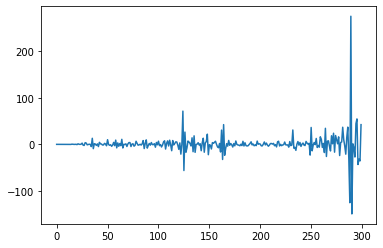

(248, 19)


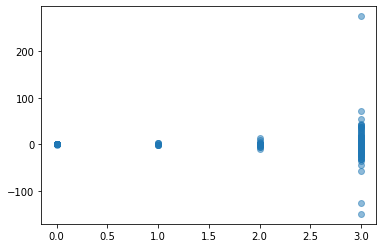

In [38]:
alameda_data = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


Using rolling_avg_new_cases/100k

['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


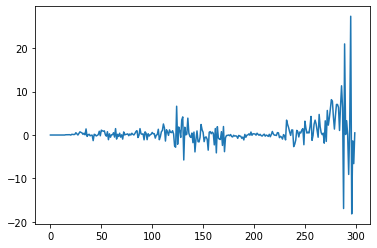

(248, 19)


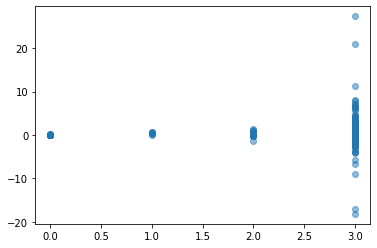

In [39]:
alameda_data = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']

rollavg_new_cases_100k_la_list = alameda_data['rolling_avg_new_cases/100k'].values
diffArr = np.diff(rollavg_new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
rollavg_new_cases_100k_la_list = alameda_data['rolling_avg_new_cases/100k'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()

## verifying Rolling average with visualizations -Los Angeles County

http://dashboard.publichealth.lacounty.gov/covid19_surveillance_dashboard/

In [40]:
CA_combined_data.Date.unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-

In [41]:
date_list_aug = ['2020-08-01',
       '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
       '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
       '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
       '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
       '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21']

date_list = ['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
       '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
       '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
       '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
       '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
       '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
       '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
       '2020-07-29', '2020-07-30', '2020-07-31']

### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

widespread

In [42]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'widespread')]['Date'].unique()

array(['2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
       '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
       '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
       '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
       '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24',
       '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
       '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
       '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
       '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
       '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
       '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
       '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22',
       '2020-06-23', '2020-06-24', '2020-06-25', '2020-

substantial

In [43]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'substantial')]['Date'].unique()

array(['2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22'],
      dtype=object)

moderate

In [44]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'moderate')]['Date'].unique()

array(['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01'], dtype=object)

minimal

In [45]:
CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & (CA_combined_data['growth_label'] == 'minimal')]['Date'].unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25'], dtype=object)

### Other

In [46]:
los_angeles_county = CA_combined_data[(CA_combined_data['County Name'] == 'Los Angeles County') & CA_combined_data['Date'].isin(date_list)]
print(los_angeles_county.shape)
los_angeles_county.head()

(31, 18)


,Date,Province_State,FIPS,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New Cases/100k population,rolling_avg_new_cases/100k,New cases,growth_label
5060,2020-07-01,California,6037,Los Angeles County,10039107,1,2.844,43,-26.0,-9.0,-4.0,-37.0,-40.0,14.0,18.079297,22.813640,1815.0,widespread
5061,2020-07-02,California,6037,Los Angeles County,10039107,1,3.032,45,-25.0,-3.0,-3.0,-36.0,-42.0,14.0,21.187143,23.074050,2127.0,widespread
5062,2020-07-03,California,6037,Los Angeles County,10039107,1,2.752,41,-27.0,5.0,-3.0,-40.0,-58.0,19.0,0.139455,20.512638,14.0,widespread
5063,2020-07-04,California,6037,Los Angeles County,10039107,1,1.081,16,-51.0,-9.0,-35.0,-44.0,-36.0,12.0,0.199221,17.703624,20.0,widespread
5064,2020-07-05,California,6037,Los Angeles County,10039107,1,0.577,8,-40.0,-21.0,-24.0,-43.0,-25.0,9.0,71.699604,24.341949,7198.0,widespread


In [47]:
los_angeles_county.growth_label.unique()

array(['widespread'], dtype=object)

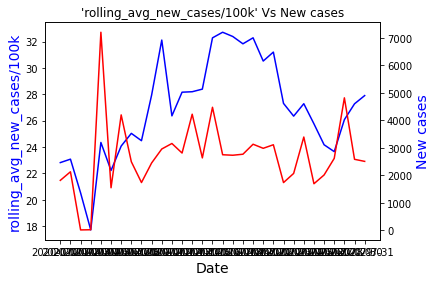

In [48]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New cases")
plt.xticks(rotation=90)
plt.show()


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 <a list of 31 Text major ticklabel objects>)

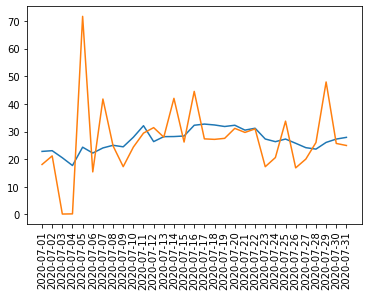

In [49]:
x = los_angeles_county['Date']
y1 = los_angeles_county['rolling_avg_new_cases/100k'] 
y2 = los_angeles_county['New Cases/100k population']


plt.plot(x,y1)
plt.plot(x,y2)
plt.xticks(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


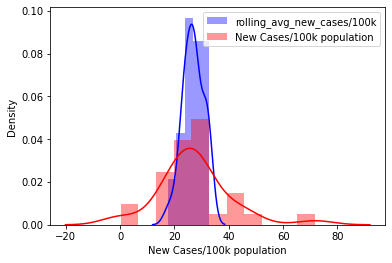

In [50]:
sns.distplot( (los_angeles_county['rolling_avg_new_cases/100k'] ) , color="blue", label='rolling_avg_new_cases/100k')
sns.distplot( los_angeles_county['New Cases/100k population'] , color="red", label='New Cases/100k population')
plt.legend()
 
plt.show()

## Riverside County

https://rivcoph.org/coronavirus

In [51]:
suffolk_county = CA_combined_data[CA_combined_data['County Name'] == 'Riverside County']

### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

widespread

In [52]:
CA_combined_data[(CA_combined_data['County Name'] == 'Riverside County') & (CA_combined_data['growth_label'] == 'widespread')]['Date'].unique()

array(['2020-06-01', '2020-06-05', '2020-06-06', '2020-06-07',
       '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11',
       '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15',
       '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
       '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23',
       '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27',
       '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01',
       '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05',
       '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
       '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
       '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
       '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
       '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
       '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
       '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02',
       '2020-08-03', '2020-08-04', '2020-08-05', '2020-

substantial

In [53]:
CA_combined_data[(CA_combined_data['County Name'] == 'Riverside County') & (CA_combined_data['growth_label'] == 'substantial')]['Date'].unique()

array(['2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
       '2020-04-12', '2020-04-14', '2020-04-15', '2020-04-16',
       '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-21',
       '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-04', '2020-05-05',
       '2020-05-06', '2020-05-07', '2020-05-09', '2020-05-10',
       '2020-05-11', '2020-05-12', '2020-05-15', '2020-05-18',
       '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
       '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26',
       '2020-05-27', '2020-05-28', '2020-05-30', '2020-05-31',
       '2020-06-02', '2020-06-03', '2020-06-04', '2020-09-07',
       '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13'],
      dtype=object)

moderate

In [54]:
CA_combined_data[(CA_combined_data['County Name'] == 'Riverside County') & (CA_combined_data['growth_label'] == 'moderate')]['Date'].unique()

array(['2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-13', '2020-04-25', '2020-05-03',
       '2020-05-08', '2020-05-13', '2020-05-14', '2020-05-16',
       '2020-05-17'], dtype=object)

minimal

In [55]:
CA_combined_data[(CA_combined_data['County Name'] == 'Riverside County') & (CA_combined_data['growth_label'] == 'minimal')]['Date'].unique()

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29'], dtype=object)

### Other

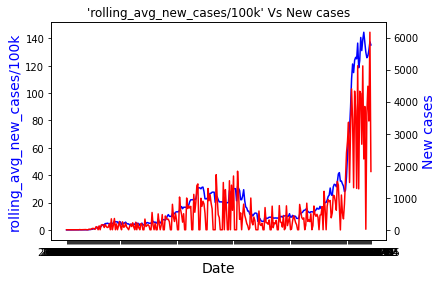

In [56]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New cases")

plt.show()

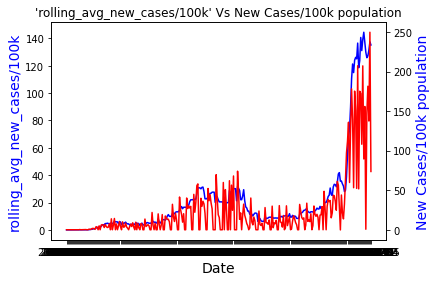

In [57]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases/100k'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases/100k",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New Cases/100k population"],color="red")
ax2.set_ylabel("New Cases/100k population",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases/100k' Vs New Cases/100k population")

plt.show()

## Export to CSV file to drive

In [58]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'CA_CombinedData_Labeled_CDCGuideline_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_data.to_csv(location+filename,index=False)

CA_CombinedData_Labeled_CDCGuideline_Jan14.csv


# 2. Loading Maryland Inertia

In [7]:
maryland_sd_inertia = pd.read_csv(location+'CA_processedMarylandData_Jan11.csv',low_memory=False)
maryland_sd_inertia.head()


,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.03,25.8,0.3,41.1,0.26,2.76,0,1666753,-2.2,2020-01-04,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.72,24.5,0.4,35.8,0.24,2.48,0,1666753,-12.1,2020-01-05,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,1.3,3.9,5.7,0.3,0.0


## Fixdate column of Social Distancing inertia

In [9]:
#old columns:

old_columns = ['CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
       'COVID death rate']

In [10]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

## Filter Data -CA State

In [11]:
maryland_sd_inertia.head(2)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.2,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.5,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0


In [12]:
maryland_sd_inertia.State.unique()

array(['CA'], dtype=object)

## 'New Cases/100k population'

In [13]:
maryland_sd_inertia.head(2)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.2,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.5,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0


In [14]:
maryland_sd_inertia['New Cases/100k population'] = maryland_sd_inertia['New.COVID.cases']*100000/ maryland_sd_inertia['population']
maryland_sd_inertia.tail(2)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population
21052,6115,Yuba County,CA,78668,6115,Yuba County,6,52,32,2.45,42.6,0.5,38.2,0.22,2.23,0,78041,-20.6,2020-12-27,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,0.3161,24.42,3,83.392041,6.7,804.58,48.33,2807,1552,39.75,0,3.3,12.6,33.7,1.71,1.52,0.000000
21053,6115,Yuba County,CA,78668,6115,Yuba County,6,43,28,2.57,46.2,0.2,40.4,0.35,2.21,37,78041,-21.3,2020-12-28,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,0.1580,24.95,4,84.355503,6.7,812.21,50.01,2902,1741,39.75,0,3.3,12.6,33.7,1.71,1.52,47.033101


## Computing rolling average

In [15]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [20]:
maryland_sd_inertia.shape

(21054, 48)

In [16]:
col_idx = maryland_sd_inertia.columns.get_loc("New Cases/100k population")
print(col_idx)

47


47 no column  = New Cases/100k population

In [21]:
maryland_sd_inertia.iloc[:,col_idx]

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
21049    78.812224
21050    94.066202
21051     0.000000
21052     0.000000
21053    47.033101
Name: New Cases/100k population, Length: 21054, dtype: float64

In [22]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [23]:
df = pd.DataFrame(columns=['County Name', 'State', 'population', 'CTFIPS', 'CTNAME','STFIPS',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home','Cumulative.inflation.rate',
       'COVID.death.rate', 'New Cases/100k population','rolling_avg_new_cases/100k'])

In [24]:
# for reference; we don't use it
df_old = pd.DataFrame(columns=['State', 'Postal Code', 'STFIPS', 'CTFIPS', 'CTNAME',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
       'COVID death rate', 'New Cases/100k population','rolling_avg_new_cases/100k'])


In [25]:
CA_counties = maryland_sd_inertia['CTNAME'].unique()

for county in CA_counties:
  county_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases/100k'] = county_data.iloc[:,45].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
0,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,NaN,6001.0
1,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,NaN,6001.0
2,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,NaN,6001.0
3,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.03,25.8,0.3,41.1,0.26,2.76,0,1666753,-2.2,2020-01-04,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,NaN,6001.0
4,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.72,24.5,0.4,35.8,0.24,2.48,0,1666753,-12.1,2020-01-05,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,1.3,3.9,5.7,0.3,0.0,0.0,NaN,6001.0


In [26]:
print(df.shape)
maryland_sd_inertia.shape

(21054, 49)


(21054, 48)

In [27]:
maryland_sd_inertia = df.copy()
maryland_sd_inertia

,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
0,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0000,0.00,0,54.000000,0.0,0.00,0.00,0,0,0.00,0,0.9,3.9,5.7,0.30,0.00,0.000000,NaN,6001.0
1,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0000,0.00,0,54.000000,0.0,0.00,0.00,0,0,0.00,0,0.9,3.9,5.7,0.30,0.00,0.000000,NaN,6001.0
2,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0000,0.00,0,54.000000,0.0,0.00,0.00,0,0,0.00,0,0.9,3.9,5.7,0.30,0.00,0.000000,NaN,6001.0
3,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.03,25.8,0.3,41.1,0.26,2.76,0,1666753,-2.2,2020-01-04,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0000,0.00,0,54.000000,0.0,0.00,0.00,0,0,0.00,0,0.9,3.9,5.7,0.30,0.00,0.000000,NaN,6001.0
4,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.72,24.5,0.4,35.8,0.24,2.48,0,1666753,-12.1,2020-01-05,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0000,0.00,0,54.000000,0.0,0.00,0.00,0,0,0.00,0,1.3,3.9,5.7,0.30,0.00,0.000000,NaN,6001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21049,Yuba County,CA,78668,6115,Yuba County,6,34,24,2.93,42.9,0.5,51.1,0.22,2.71,62,78041,-3.5,2020-12-24,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,1.2558,22.51,0,80.765219,6.5,777.86,46.67,2549,1619,39.82,0,3.3,12.6,33.7,1.71,1.52,78.812224,1.71,6115.0
21050,Yuba County,CA,78668,6115,Yuba County,6,62,37,1.78,51.5,0.4,37.5,0.22,1.56,74,78041,-44.5,2020-12-25,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,0.8799,22.63,1,81.599790,6.6,785.37,46.28,2631,1430,39.75,0,3.3,12.6,33.7,1.71,1.52,94.066202,1.71,6115.0
21051,Yuba County,CA,78668,6115,Yuba County,6,43,29,2.59,46.3,0.5,50.0,0.22,2.37,0,78041,-15.6,2020-12-26,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,0.5809,23.86,2,82.474011,6.6,794.97,47.38,2717,1657,39.75,0,3.3,12.6,33.7,1.71,1.52,0.000000,1.71,6115.0
21052,Yuba County,CA,78668,6115,Yuba County,6,52,32,2.45,42.6,0.5,38.2,0.22,2.23,0,78041,-20.6,2020-12-27,0.94,17,52624,3.1,27.8,50.96,117,27,76,2.05,0.22,NaN,0.3161,24.42,3,83.392041,6.7,804.58,48.33,2807,1552,39.75,0,3.3,12.6,33.7,1.71,1.52,0.000000,1.71,6115.0


In [28]:
maryland_sd_inertia[maryland_sd_inertia['date'] == '2020-08-01'].head(4)

,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
213,Alameda County,CA,1671329,6001,Alameda County,6,46,31,2.97,24.3,0.2,28.1,0.21,2.76,345,1666753,-2.2,2020-08-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.1422,6.52,2,56.066326,6.3,199.37,24.31,629,5243,6.31,133,5.8,12.2,42.0,1.51,3.74,20.642255,1.158571,6001.0
576,Alpine County,CA,1129,6003,Alpine County,6,16,20,7.44,44.9,18.9,120.1,0.18,7.26,0,1101,143.6,2020-08-01,0.28,35,64688,0.8,9.2,53.40,2,8,293,2.05,0.22,NaN,0.0000,6.52,95,56.066326,6.3,199.37,24.31,629,34,6.31,133,5.8,12.2,42.0,1.51,3.74,0.000000,1.158571,6003.0
939,Amador County,CA,39752,6005,Amador County,6,24,22,3.04,36.4,0.9,53.6,0.21,2.83,10,39383,9.6,2020-08-01,0.16,35,61198,2.0,13.6,53.67,63,20,147,2.05,0.22,NaN,0.3047,6.52,0,56.066326,6.3,199.37,24.31,629,233,6.31,133,5.8,12.2,42.0,1.51,3.74,25.155967,1.158571,6005.0
1302,Butte County,CA,219186,6007,Butte County,6,31,26,3.17,14.0,0.2,37.0,0.24,2.93,0,231256,-1.9,2020-08-01,1.18,24,48443,1.5,16.0,49.55,135,45,132,2.05,0.22,NaN,0.0836,6.52,6,56.066326,6.3,199.37,24.31,629,417,6.31,133,5.8,12.2,42.0,1.51,3.74,0.000000,1.158571,6007.0


## clean data - fill NA 

In [29]:
maryland_sd_inertia = maryland_sd_inertia.fillna(0)
maryland_sd_inertia.head(8)

,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,countyFIPS
0,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,0.0,6001.0
1,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,0.0,6001.0
2,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,0.0,6001.0
3,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.03,25.8,0.3,41.1,0.26,2.76,0,1666753,-2.2,2020-01-04,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0,0.0,6001.0
4,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.72,24.5,0.4,35.8,0.24,2.48,0,1666753,-12.1,2020-01-05,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,1.3,3.9,5.7,0.3,0.0,0.0,0.0,6001.0
5,Alameda County,CA,1671329,6001,Alameda County,6,19,21,3.24,28.9,0.4,37.4,0.56,2.68,0,1666753,-5.1,2020-01-06,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,1.3,3.9,5.7,0.3,0.0,0.0,0.0,6001.0
6,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.25,29.2,0.3,33.8,0.56,2.68,0,1666753,-5.1,2020-01-07,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,7,1.3,3.9,5.7,0.3,0.0,0.0,0.3,6001.0
7,Alameda County,CA,1671329,6001,Alameda County,6,19,20,3.27,29.5,0.2,34.1,0.58,2.69,0,1666753,-4.7,2020-01-08,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,7,1.3,3.9,5.7,0.3,0.0,0.0,0.3,6001.0


## Labeling: Apply CDC Guideline for all counties

https://edsource.org/2020/quick-guide-what-californias-color-coded-county-tracking-system-means-for-schools/639357

In [30]:
county_names = maryland_sd_inertia['CTNAME'].unique()

* Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
* Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
* Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
* Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity

In [31]:
for county in county_names:   
    print('county :',county)
    county_population = maryland_sd_inertia[maryland_sd_inertia['CTNAME']== county].Population.unique()[0]
    county_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME']== county]
    new_cases_100k_la_list = county_data['New Cases/100k population'].values
    diffArr = np.diff(new_cases_100k_la_list)
    


    diffArr = np.diff(new_cases_100k_la_list)
    growth_values =[]
    growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    growth_values.extend(diffArr)
    county_data['growth_values'] = growth_values

    minVal = np.min(growth_values)
    maxVal = np.max(growth_values)
    meanVal= np.mean(growth_values, axis=0)
    stdVal = np.std(growth_values, axis=0)

#implementing cdc guideline-CA color code
#Widespread (purple): Counties with more than 7 daily new cases per 100,000 residents or higher than 8% positivity rate
#Substantial (red): 4 to 7 daily new cases per 100,000 residents or 5-8% positivity
#Moderate (orange): 1 to 3.9 daily new cases per 100,000 or 2-4.9% positivity
#Minimal (yellow): Less than 1 daily new case per 100,000 or less than 2% positivity
    for index, row in (county_data.iterrows()):
      i = row['rolling_avg_new_cases/100k']
      if i > 7 :
        label = 'widespread'
      elif (i <= 7) and (i >= 4):
        label = 'substantial'
      elif (i < 4) and (i >= 1):
        label = 'moderate'
      elif i < 1 :
        label = 'minimal'
          
    
      date = row['date']
      #print(i,county, date, label)

      df_index = (maryland_sd_inertia['CTNAME'] == county) & (maryland_sd_inertia['date'] == date) 
      #print(df_weekData)
      maryland_sd_inertia.loc[df_index,'growth_label'] = label
    #break

county : Alameda County


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


county : Alpine County
county : Amador County
county : Butte County
county : Calaveras County
county : Colusa County
county : Contra Costa County
county : Del Norte County
county : El Dorado County
county : Fresno County
county : Glenn County
county : Humboldt County
county : Imperial County
county : Inyo County
county : Kern County
county : Kings County
county : Lake County
county : Lassen County
county : Los Angeles County
county : Madera County
county : Marin County
county : Mariposa County
county : Mendocino County
county : Merced County
county : Modoc County
county : Mono County
county : Monterey County
county : Napa County
county : Nevada County
county : Orange County
county : Placer County
county : Plumas County
county : Riverside County
county : Sacramento County
county : San Benito County
county : San Bernardino County
county : San Diego County
county : San Francisco County
county : San Joaquin County
county : San Luis Obispo County
county : San Mateo County
county : Santa Bar

In [33]:
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'widespread'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'substantial'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'moderate'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'minimal'].shape)

(0, 50)
(0, 50)
(10208, 50)
(10846, 50)


## Verifying the labeling with plot- Los Angeles

['minimal' 0 'moderate' 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


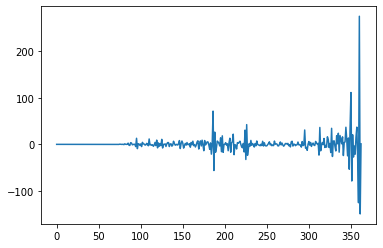

(0, 51)


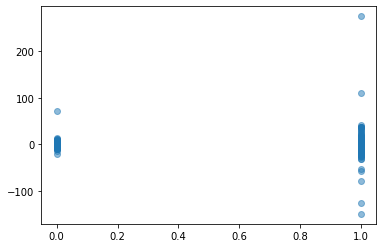

In [34]:
alameda_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == 'Los Angeles County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


### ['minimal' 0 'moderate' 1 'substantial' 2 'widespread' 3]

widespread

In [35]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Los Angeles County') & (maryland_sd_inertia['growth_label'] == 'widespread')]['date'].unique()

array([], dtype=object)

substantial

In [36]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Los Angeles County') & (maryland_sd_inertia['growth_label'] == 'substantial')]['date'].unique()

array([], dtype=object)

moderate

In [37]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Los Angeles County') & (maryland_sd_inertia['growth_label'] == 'moderate')]['date'].unique()

array(['2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
       '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
       '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
       '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
       '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
       '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
       '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02',
       '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
       '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10',
       '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14',
       '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-18',
       '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-22',
       '2020-08-23', '2020-08-24', '2020-08-25', '2020-08-26',
       '2020-08-27', '2020-08-28', '2020-08-29', '2020-08-30',
       '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03',
       '2020-09-04', '2020-09-05', '2020-09-06', '2020-

minimal

In [38]:
maryland_sd_inertia[(maryland_sd_inertia['CTNAME'] == 'Los Angeles County') & (maryland_sd_inertia['growth_label'] == 'minimal')]['date'].unique()

array(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
       '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-

## Verifying the labeling with plot- Reverside

In [39]:
maryland_sd_inertia['CTNAME'].unique()

array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
       'Napa County', 'Nevada County', 'Orange County', 'Placer County',
       'Plumas County', 'Riverside County', 'Sacramento County',
       'San Benito County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Sierra County', 'Siskiyou County',
       'Solano 

['minimal' 0 'moderate' 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


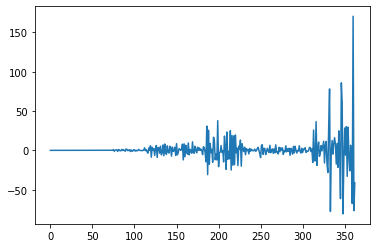

(0, 51)


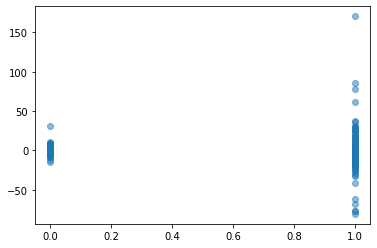

In [41]:
alameda_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == 'San Diego County']

new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
diffArr = np.diff(new_cases_100k_la_list)
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
    
growth_values.extend(diffArr)

alameda_data['growth_code'] = alameda_data['growth_label'].astype('category').cat.codes
print(pd.unique(alameda_data[['growth_label', 'growth_code']].values.ravel()))
new_cases_100k_la_list = alameda_data['New Cases/100k population'].values
plt.plot(growth_values)
plt.show()
alameda_labelflat_growth = alameda_data[alameda_data['growth_label'] == 'widespread']
print(alameda_labelflat_growth.shape)
#alameda_labelflat_growth

N = 5
x = alameda_data['growth_code'].values
y = growth_values #alameda_data['New Cases/1k population'].values
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()


## Export to csv

In [42]:
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'widespread'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'substantial'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'moderate'].shape)
print(maryland_sd_inertia[maryland_sd_inertia['growth_label'] == 'minimal'].shape)

(0, 50)
(0, 50)
(10208, 50)
(10846, 50)


In [43]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'CA_MarylandData_Labeled_CDCGuideline_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
maryland_sd_inertia.to_csv(location+filename,index=False)

CA_MarylandData_Labeled_CDCGuideline_Jan14.csv
